In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

In [5]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [6]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = np.int32(y)

We'll start with our standard PCE to 2d

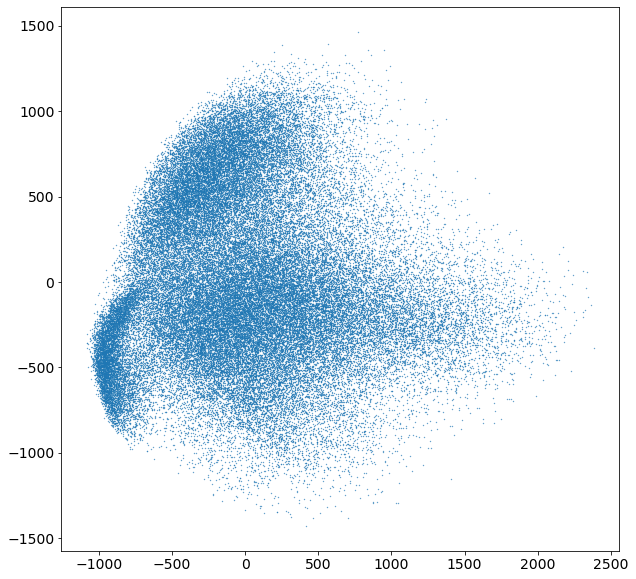

In [7]:
p = PCA(n_components=2)
p.fit_transform(X)
reduced_data = p.transform(X)
digits_rec = p.inverse_transform(reduced_data) #+ mean

plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, cmap=plt.cm.get_cmap('Spectral', 10))

The large difference to, for example clustering, is that now we have the truth lables! Let's plot them:

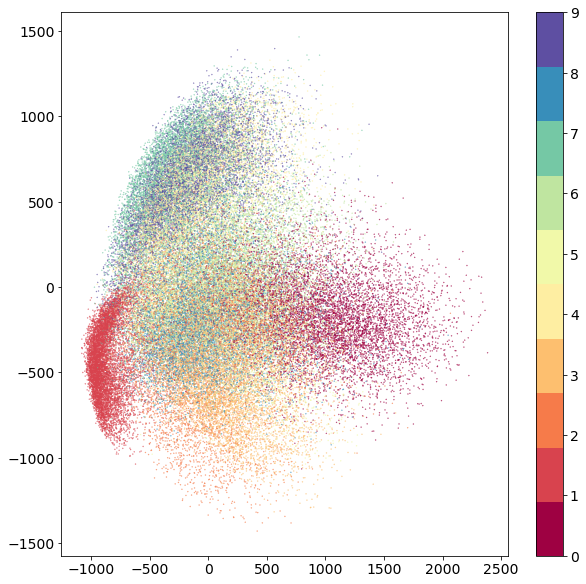

In [8]:
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
#plt.savefig('mnist_true_labels.png', bbox_inches='tight')

## Binary classification

To reduce the problem, we start with binary classification, trying to distinguish the digits (1, 4, 5, 7, 9) from the rest.

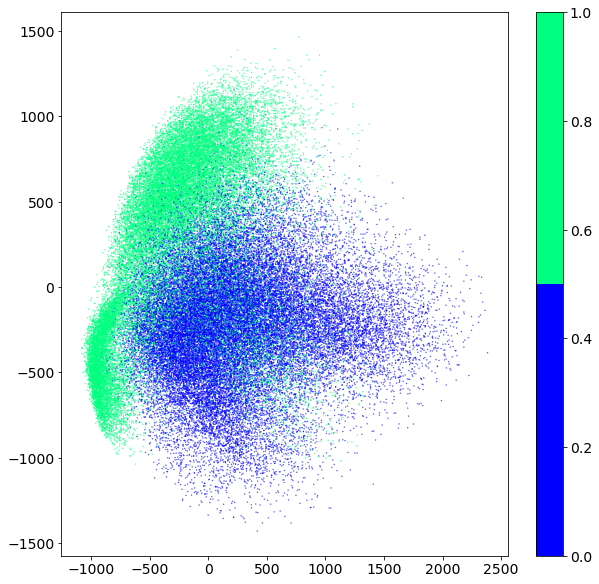

In [9]:
# do binary classification first

target = ((y == 1) | (y == 9) | (y == 5) | (y == 7) | (y == 4)).astype(np.float32)

plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1, c=target ,cmap=plt.cm.get_cmap("winter", 2))
plt.colorbar()
#plt.savefig('mnist_binary_labels.png', bbox_inches='tight')

We always split data into independent training and testing samples!

In [10]:
X_train = reduced_data[:60000]
X_test = reduced_data[60000:]

In [11]:
y_train = target[:60000]
y_test = target[60000:]

Use a classifier, try out different ones and different settings!

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, max_depth=7) #DecisionTreeClassifier(max_depth=4))
name = "BDT"

In [13]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()

In [14]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier()

In [15]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(max_depth=10, )
# name = 'max. depth = %s'%clf.max_depth

In [28]:
#from sklearn.ensemble import RandomForestRegressor
#clf = RandomForestRegressor(n_estimators=20, max_depth=7, criterion='mse') #DecisionTreeClassifier(max_depth=4))

this does the learning:

In [23]:
clf.fit(X_train, y_train, )

RandomForestClassifier(max_depth=7, n_estimators=20)

The following produces predicted lables:

In [44]:
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)

While this produces a probability output for each class

In [45]:
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)

We can plot the classifier outputs for the testing and training samples of both classes

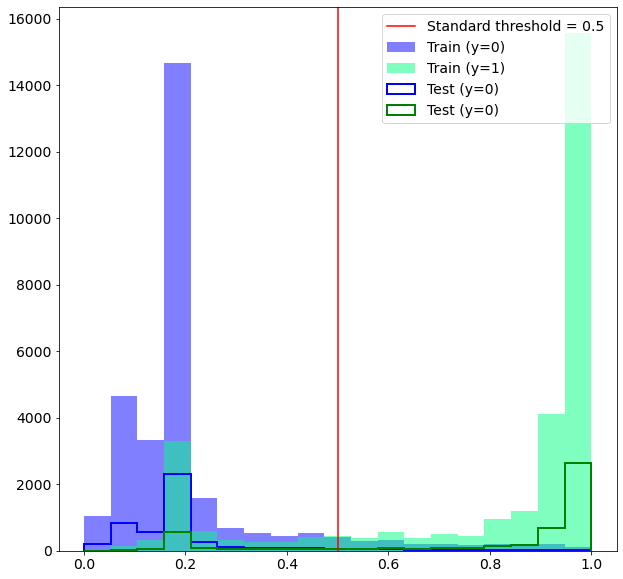

In [46]:
bins = np.linspace(0, 1, 20)
plt.hist(y_predicted[y_train==0][:,1], bins=bins, color=plt.cm.winter(0), label='Train (y=0)', alpha=0.5)
plt.hist(y_predicted[y_train==1][:,1], bins=bins, color=plt.cm.winter(1000), label='Train (y=1)', alpha=0.5)
plt.hist(y_test_predicted[y_test==0][:,1], bins=bins, color=plt.cm.winter(0), histtype='step', lw=2, label='Test (y=0)', hatch='77')
plt.hist(y_test_predicted[y_test==1][:,1], bins=bins, color='green', histtype='step', lw=2, label='Test (y=0)')
plt.axvline(0.5, color='red', label = 'Standard threshold = 0.5')
plt.legend()
#plt.savefig('DT_dist.png', bbox_inches='tight')

Amd this is how the predicted lables look in our scattering plot:

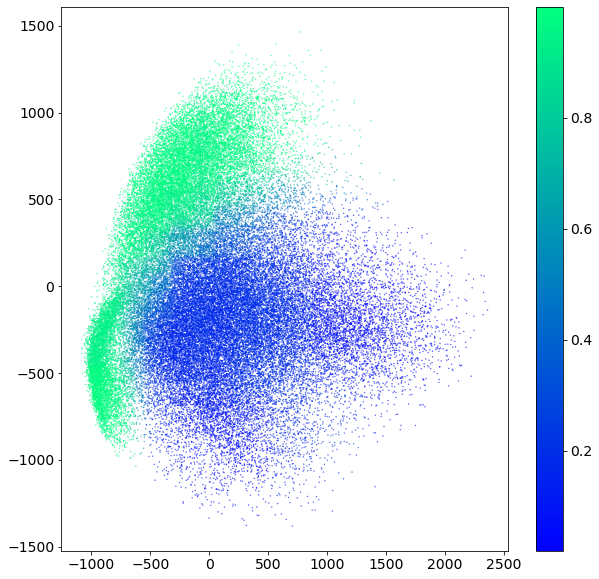

In [48]:
plt_data = plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, c=y_predicted[:,1] ,cmap="winter")
plt.colorbar()
#plt.savefig('DT_proba.png', bbox_inches='tight')

How well is the classification dping? We can construct the confusion matrix:

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted_label, )

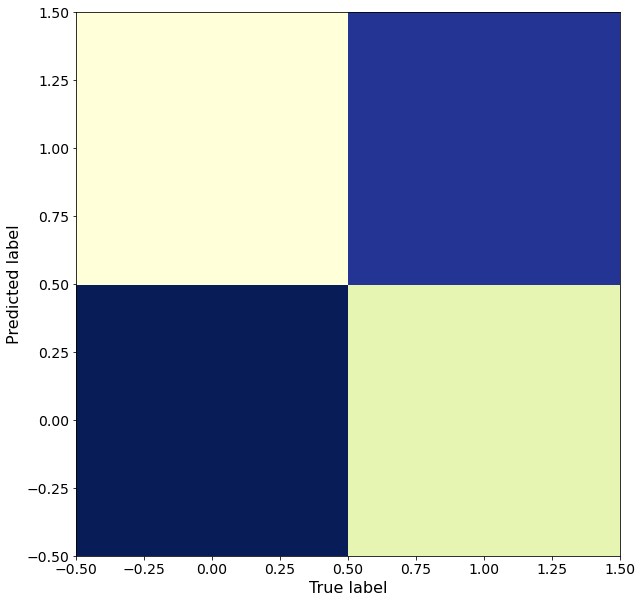

In [50]:
plt.imshow(cm.T, cmap='YlGnBu', origin='lower')
plt.gca().set_xlabel('True label')
plt.gca().set_ylabel('Predicted label')
plt.savefig('DT_confusion.png', bbox_inches='tight')

## ROC curves

Further insight provides the ROC curve (as discussed in the lecture).

As it can be a bit difficult to understand at first, I highly recommen for you to construct some ROC curves by hand! Here we use the built-in function.

In [51]:
fpr_test = {}
tpr_test = {}
fpr_train = {}
tpr_train = {}

In [52]:
fpr_test[name], tpr_test[name], _ = roc_curve(y_test, y_test_predicted[:,1])
fpr_train[name], tpr_train[name], _ = roc_curve(y_train, y_predicted[:,1])

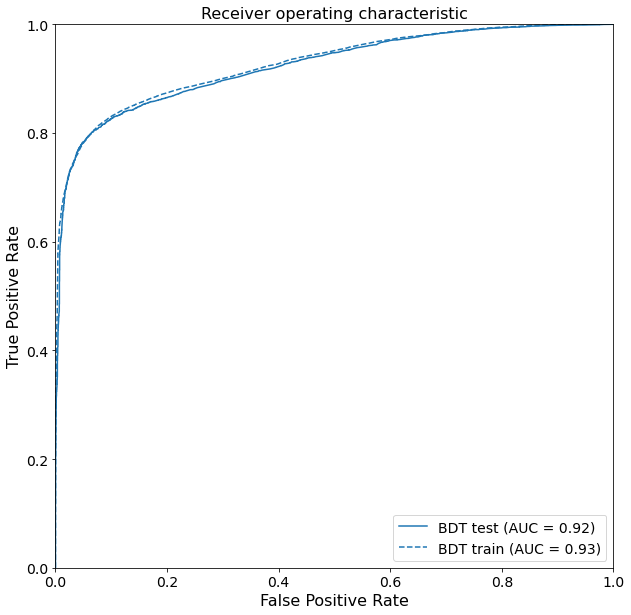

In [53]:
for key in tpr_test.keys():
    if key == 'max. depth = 50': continue
    bl = plt.plot(fpr_test[key], tpr_test[key], ls='-', label='%s test (AUC = %0.2f)' %(key,auc(fpr_test[key], tpr_test[key])))
    plt.plot(fpr_train[key], tpr_train[key], ls='--', c=bl[0].get_color(), label='%s train (AUC = %0.2f)' %(key, auc(fpr_train[key], tpr_train[key])))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('overtraining.png', bbox_inches='tight')

Here we plot some of the testing data that was preducted to be of class (1, 4, 5, 7, 9)

Text(0.5, 0.98, 'Class: 1, 4, 5, 7, 9')

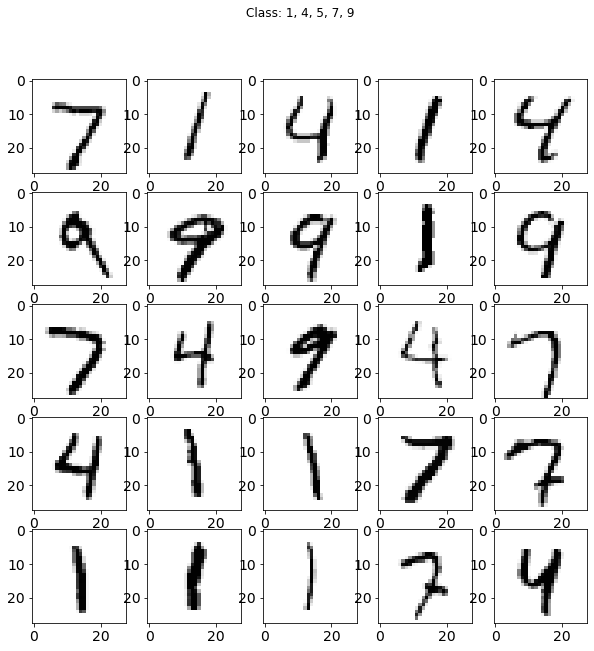

In [56]:
X_plot = X[60000:]

mask = y_test_predicted_label == 1

fig, ax = plt.subplots(5,5)
for i in range(25):
    axis = ax[i//5, i%5]
    axis.imshow(X_plot[mask][i].reshape(28,28), cmap='Greys')
    
    
plt.suptitle('Class: 1, 4, 5, 7, 9')
#plt.suptitle('Class: 0, 2, 3, 6, 8')
    
#plt.savefig('mnist.png', bbox_inches='tight')

## Exercise

Implement a multi-label classification for all 10 digits!